# Gibbs chain verification

In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import numpyro
from functools import partial
import micmac as micmac

from jax import config
config.update("jax_enable_x64", True)

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
# from get_freq_maps_SO_64 import *
from get_freq_maps_LiteBIRD_64 import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (15, 2, 49152)
Shape for input cmb maps : (15, 2, 49152)


In [3]:
path_Fisher =  '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_sampling_step_4/fisher_litebird_d0s0_lmin2_lmax128_masked_Alens1.0_r0.0_B_noiselens_synchdust.txt'
Fisher_matrix = np.loadtxt(path_Fisher)

In [4]:
# Getting the parameters of the problem
nstokes = 2
nside = 64
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

n_iter = 8
number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))


param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2

# Getting C_approx and a first guess for C
input_cmb_maps_extended = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]),input_cmb_maps[0]])
initial_spectra = hp.anafast(input_cmb_maps_extended, lmax=lmax, iter=n_iter)
initial_spectra[0,:] = 0
initial_spectra[nstokes+2:,:] = 0

c_ells_input = np.zeros((6,lmax+1))
c_ell_approx = np.zeros((6,lmax+1))

c_ells_input[:4,...] = initial_spectra[:4,:]
c_ell_approx[1] = initial_spectra[1,:]
c_ell_approx[2] = initial_spectra[2,:]

indices_polar = np.array([1,2,4])

if nstokes == 2 and (c_ells_input.shape[0] != len(indices_polar)):    
    c_ells_input = c_ells_input[indices_polar,:]
    c_ell_approx = c_ell_approx[indices_polar,:]
    # CMB_map_input = CMB_map_input[1:,:]
    # freq_maps = freq_maps[:,1:,:]

# CMB covariance preparation
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[lmin:,...]
red_cov_matrix_sample = micmac.get_reduced_matrix_from_c_ell(c_ells_input)[lmin:,...]

# Mixing matrix initialization
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[0,-1])

init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[0,-1])
mixing_matrix_sampled = mixing_matrix_obj.get_B()


minimum_std_Fisher = scipy.linalg.sqrtm(np.linalg.inv(Fisher_matrix))
minimum_std_Fisher_diag = np.diag(minimum_std_Fisher)

len_pos_special_freqs = len(mixing_matrix_obj.pos_special_freqs)
number_steps_sampler = 100


# Noise initialization
freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p'], nside)
BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)


# Studying the sampling !

In [5]:
file_ver = 'full_Gchain_v1a'
number_iterations_sampling = 5

In [6]:
directory_save_file = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v1/save_directory/'

initial_freq_maps_path = directory_save_file+file_ver+'_initial_data.npy'
initial_freq_maps = np.load(initial_freq_maps_path)

all_eta_maps_path = directory_save_file+file_ver+'_all_eta_maps.npy'
all_eta_maps = np.load(all_eta_maps_path)

all_s_c_WF_maps_path = directory_save_file+file_ver+'_all_s_c_WF_maps.npy'
all_s_c_WF_maps = np.load(all_s_c_WF_maps_path)

all_s_c_fluct_maps_path = directory_save_file+file_ver+'_all_s_c_fluct_maps.npy'
all_s_c_fluct_maps = np.load(all_s_c_fluct_maps_path)

all_cell_samples_path = directory_save_file+file_ver+'_all_cell_samples.npy'
all_cell_samples = np.load(all_cell_samples_path)

all_params_mixing_matrix_samples_path = directory_save_file+file_ver+'_all_params_mixing_matrix_samples.npy'
all_params_mixing_matrix_samples = np.load(all_params_mixing_matrix_samples_path)


In [7]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

## Testing $\eta$

In [8]:
red_cov_approx_matrix_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix))
red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)

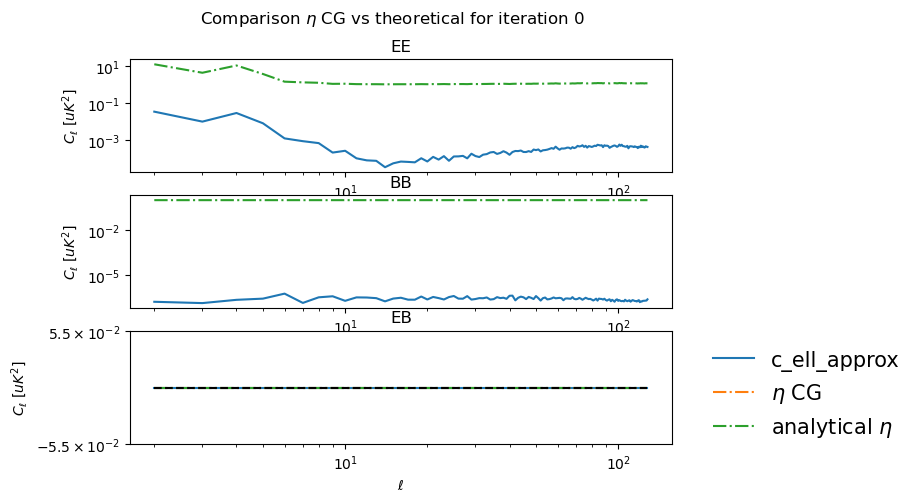

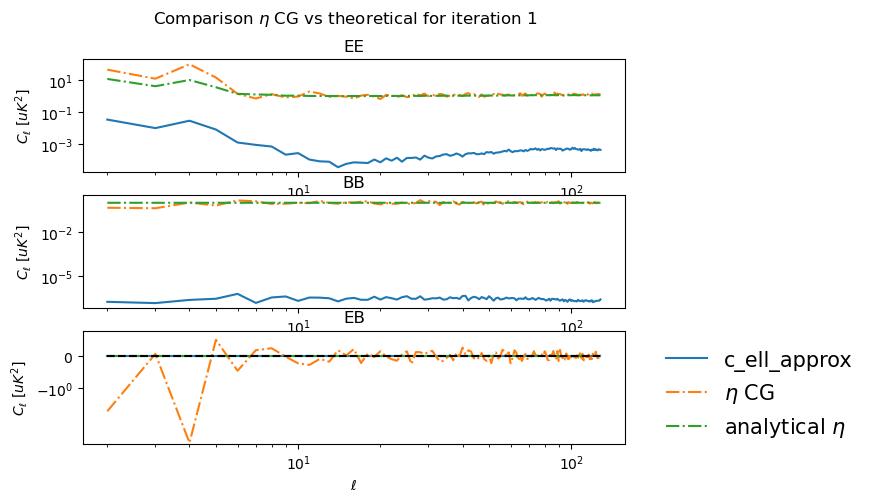

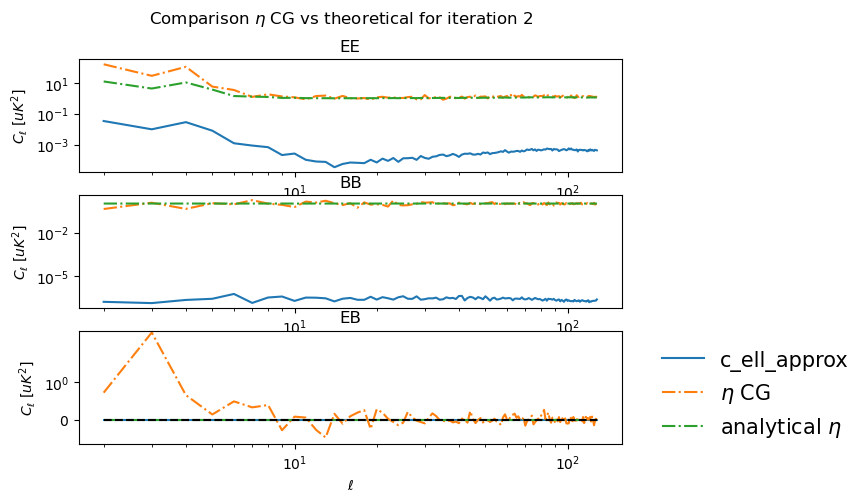

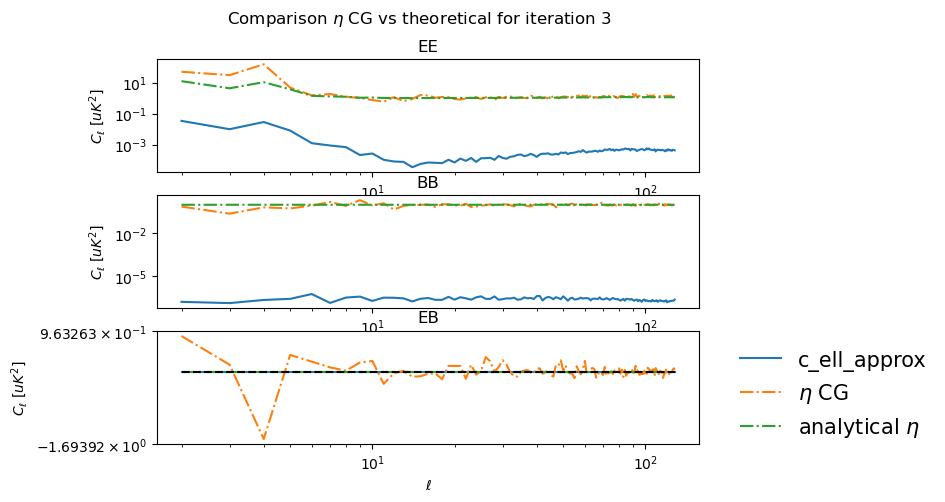

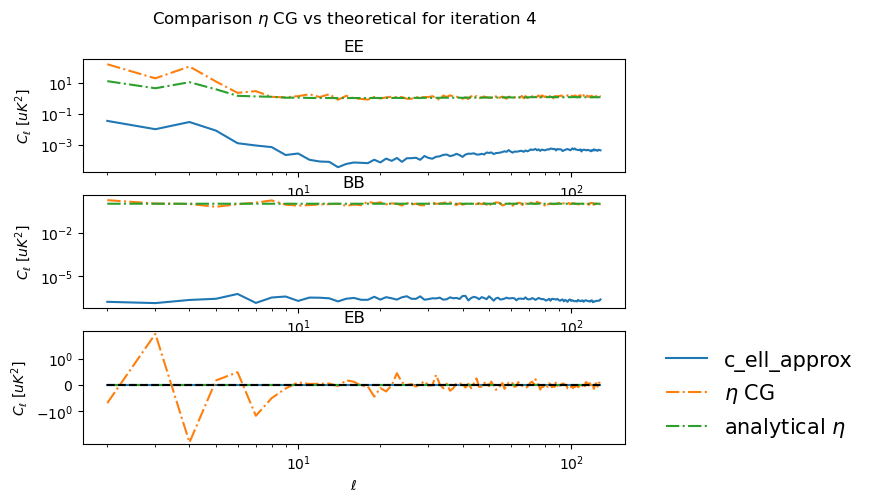

In [9]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

for iteration in range(number_iterations_sampling):
    covariance_noise = np.zeros_like(c_ell_approx)

    mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
    mixing_matrix_sampled = mixing_matrix_obj.get_B()
    BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
    BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
    BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

    analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + np.eye(nstokes)/BtinvNB[0,0], red_cov_approx_matrix_sqrt)
    # analytical_eta_term = np.zeros_like(c_ell_approx)
    analytical_eta_term = get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov)#[:,lmin:]



    eta_maps_extended = np.vstack([np.zeros_like(all_eta_maps[iteration,0,...]), all_eta_maps[iteration]])
    c_ells_eta = hp.anafast(eta_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    plt.figure(figsize=(7,5))
    plt.suptitle(r"Comparison $\eta$ CG vs theoretical for iteration {}".format(iteration))

    for j in range(number_correl_to_plot):
        ax = plt.subplot(311+j)
        plt.title(list_correl[j])

        plt.plot(ell_arange, c_ell_approx[j,lmin:], label='c_ell_approx')
        plt.plot(ell_arange, c_ells_eta[j,:], '-.', label=r"$\eta$ CG")
        
        plt.plot(ell_arange, analytical_eta_term[j,:], '-.', label=r"analytical $\eta$")
        
        plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
        if nstokes == 3 and j < number_correl_to_plot-2:
            plt.xticks(color='w')

        if j <= nstokes-1:
            plt.loglog()
            # plt.ylim(ymin=noise_level/10.)
        else:
            plt.xscale('log')
            plt.yscale('symlog')
        # plt.legend()
        if j == position_legend:
            plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        
        plt.ylabel("$C_\ell$ [$uK^2$]")
        if j == number_correl_to_plot-1:
            plt.xlabel(r"$\ell$")


    plt.show()

In [10]:
all_cell_samples[iteration,...].shape

(3, 129)

# Validation $s_c$

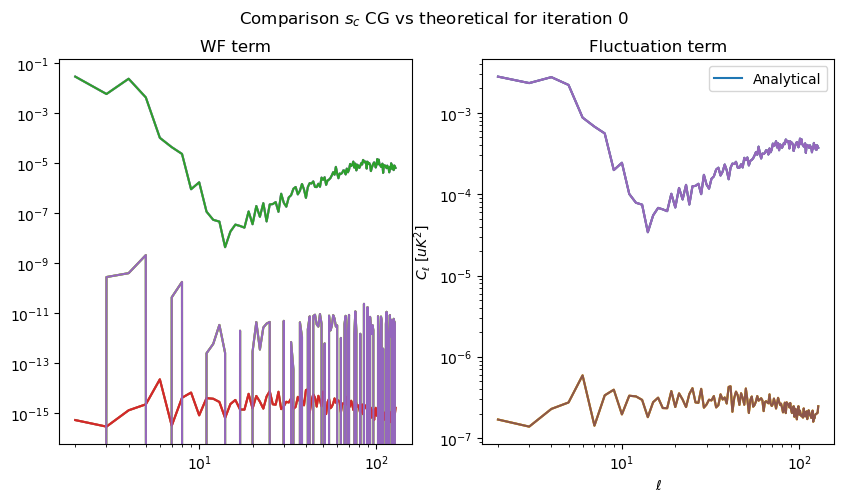

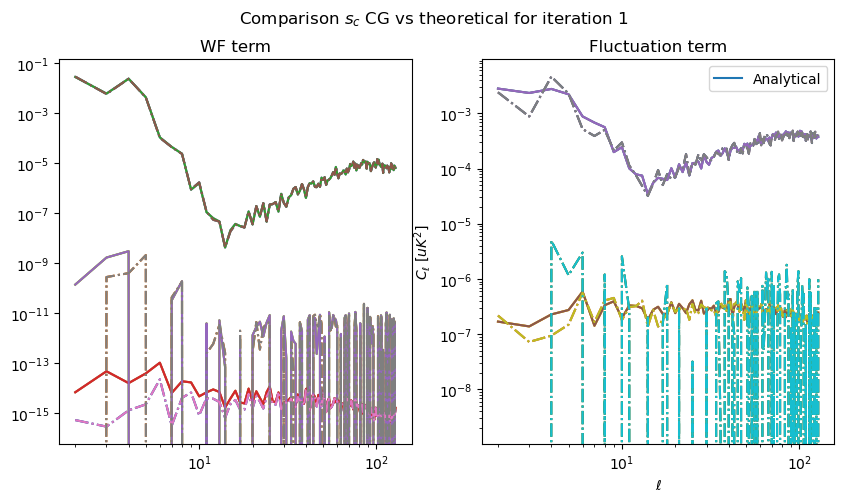

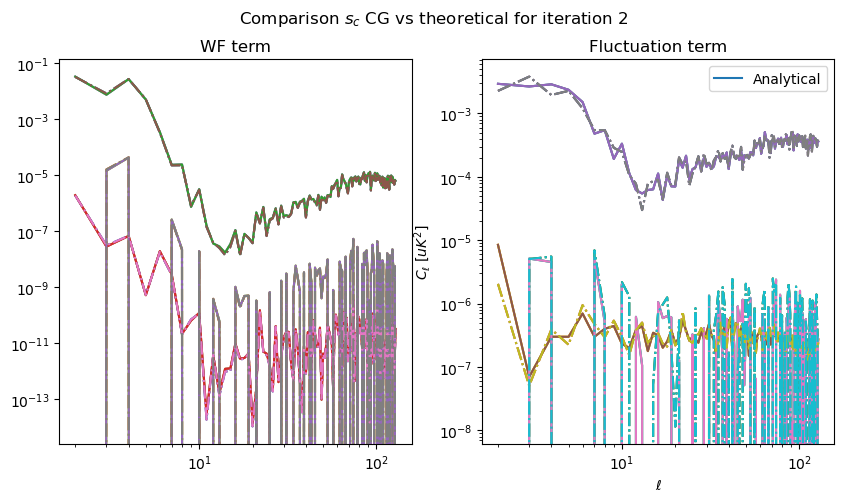

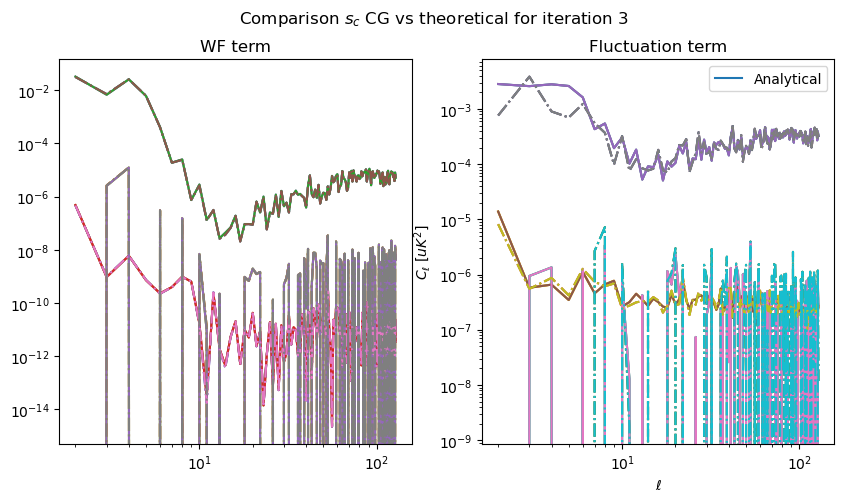

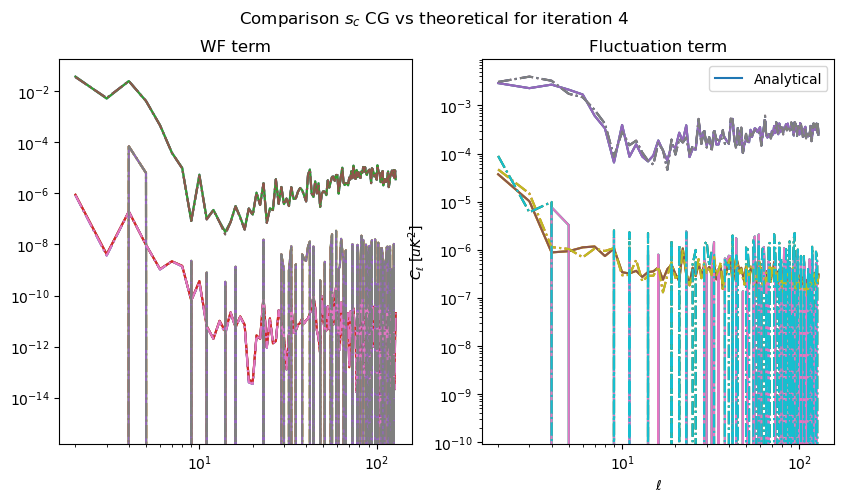

In [11]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

for iteration in range(number_iterations_sampling):
    covariance_noise = np.zeros_like(c_ell_approx)

    mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
    mixing_matrix_sampled = mixing_matrix_obj.get_B()
    BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
    BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
    BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
    s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps, jax_use=False)[0]

    red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration,...])[lmin:]
    if iteration != 0:
        red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration-1,...])[lmin:]

    analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.eye(nstokes)/BtinvNB[0,0])
    analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=lmin, n_iter=n_iter)

    analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
    analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
    analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

    s_c_WF_maps_extended = np.vstack([np.zeros_like(all_s_c_WF_maps[iteration,0,...]), all_s_c_WF_maps[iteration]])
    c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    s_c_fluct_maps_extended = np.vstack([np.zeros_like(all_s_c_fluct_maps[iteration,0,...]), all_s_c_fluct_maps[iteration]])
    c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    plt.figure(figsize=(10,5))
    plt.suptitle(r"Comparison $s_c$ CG vs theoretical for iteration {}".format(iteration))

    for j in range(number_correl_to_plot):
        plt.subplot(121)
        
        plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, analytical_WF_cells.T, label='Analytical WF')
        plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ells_s_c_WF.T, '-.')
        plt.loglog()
        plt.title('WF term')

        plt.subplot(122)
        plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, analytical_fluct_c_ell.T, label='Analytical fluct')
        plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c_fluct.T, '-.')

        plt.loglog([])
        plt.title('Fluctuation term')
        plt.legend(['Analytical'])
        
        
        plt.ylabel("$C_\ell$ [$uK^2$]")
        if j == number_correl_to_plot-1:
            plt.xlabel(r"$\ell$")


    plt.show()

In [12]:
mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[0])
mixing_matrix_sampled = mixing_matrix_obj.get_B()
micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps, jax_use=False)[0]

array([[ 0.30080645,  0.92049132, -0.21519836, ...,  0.9645131 ,
        -0.42830996,  0.83724566],
       [ 0.60645694, -1.74524708,  1.26930988, ...,  0.40044183,
        -0.00520235, -0.24054575]])

# Plot $C$

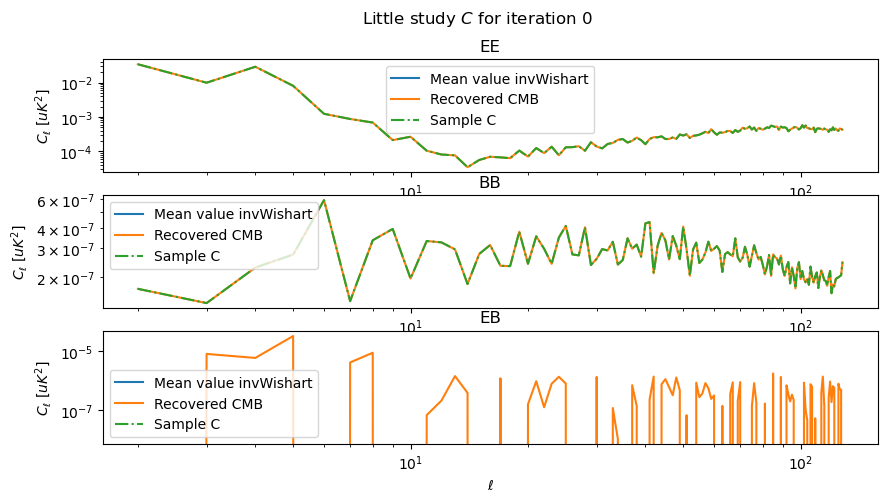

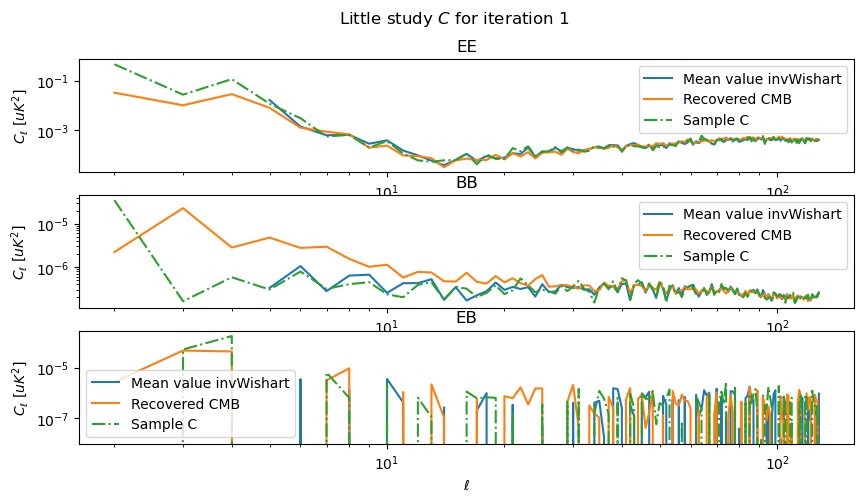

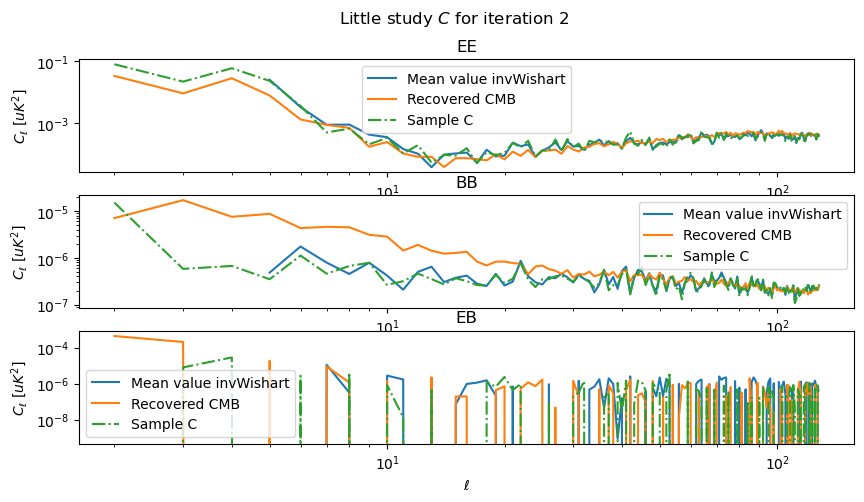

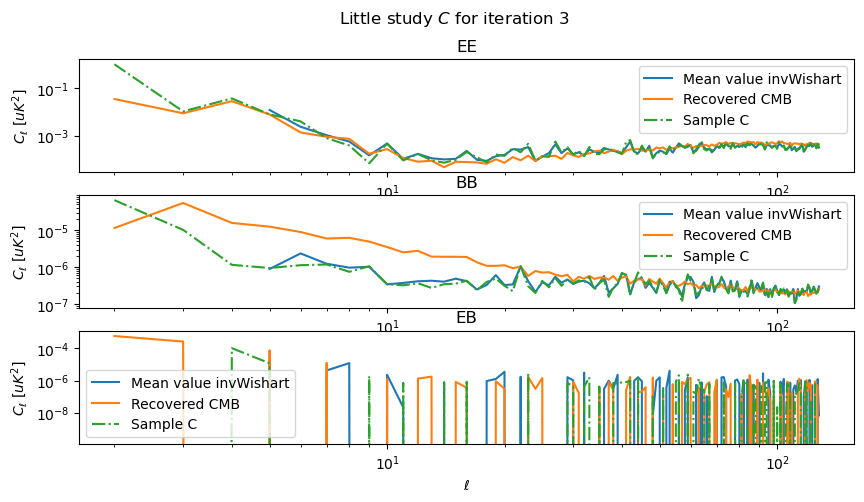

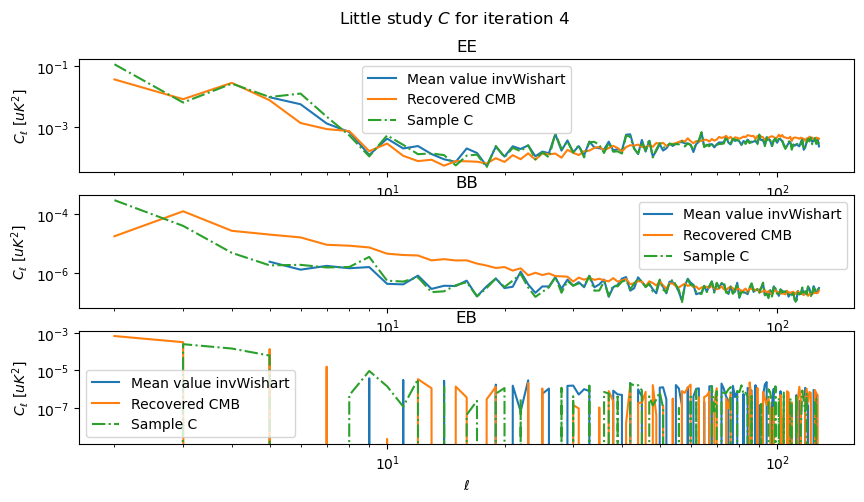

In [13]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin
min_value_mean = 3
factor_mean = (2*ell_arange[min_value_mean:] + 1)/(2*ell_arange[min_value_mean:] + 1 - 2 - 2*nstokes)

for iteration in range(number_iterations_sampling):
    covariance_noise = np.zeros_like(c_ell_approx)

    mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
    mixing_matrix_sampled = mixing_matrix_obj.get_B()
    BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
    BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
    BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
    s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps, jax_use=False)[0]
    full_map_s_c = all_s_c_WF_maps[iteration] + all_s_c_fluct_maps[iteration]
    # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration,...])[lmin:]

    full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
    c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    full_map_s_c_extended = np.vstack([np.zeros_like(full_map_s_c[0,...]), full_map_s_c])
    c_ell_s_c = hp.anafast(full_map_s_c_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    plt.figure(figsize=(10,5))
    plt.suptitle(r"Little study $C$ for iteration {}".format(iteration))

    for j in range(number_correl_to_plot):
        ax = plt.subplot(311+j)
        plt.title(list_correl[j])

        plt.plot(ell_arange[min_value_mean:], c_ell_s_c[j,min_value_mean:]*factor_mean, label='Mean value invWishart')
        plt.plot(ell_arange, c_ell_s_cML[j,...], label='Recovered CMB')
        plt.plot(ell_arange, all_cell_samples[iteration,j,lmin:], '-.', label='Sample C')
        
        plt.loglog()
        plt.legend()
        
        
        plt.ylabel("$C_\ell$ [$uK^2$]")
        if j == number_correl_to_plot-1:
            plt.xlabel(r"$\ell$")


    plt.show()

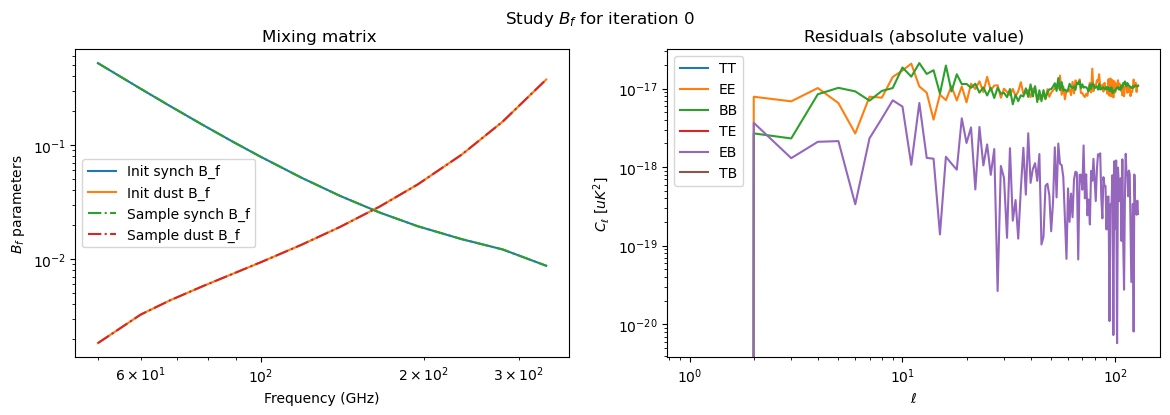

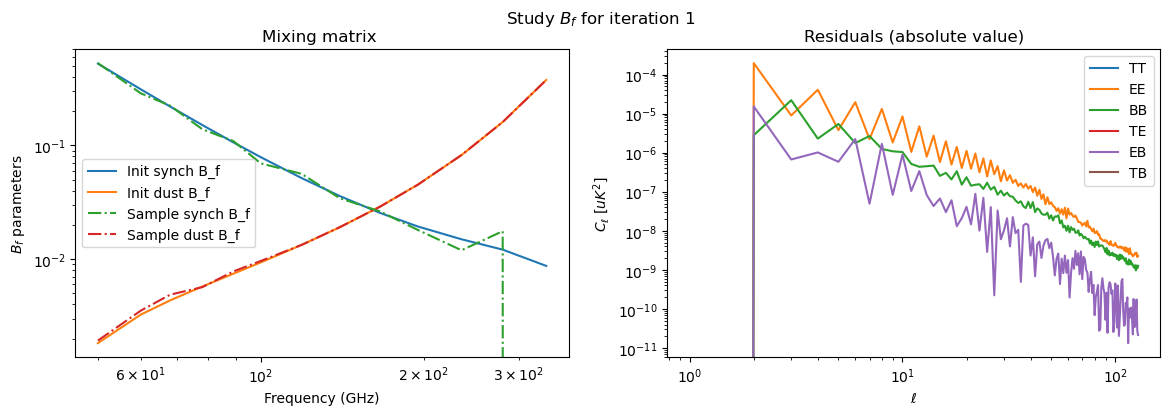

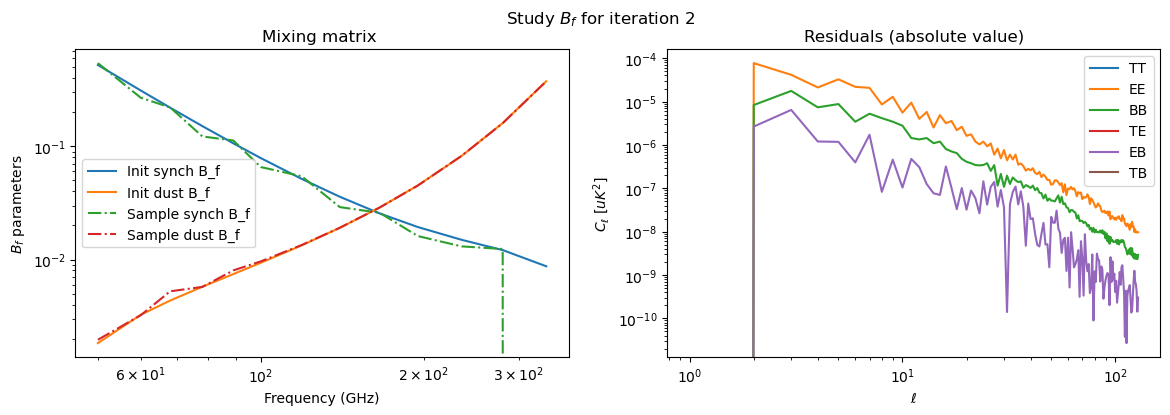

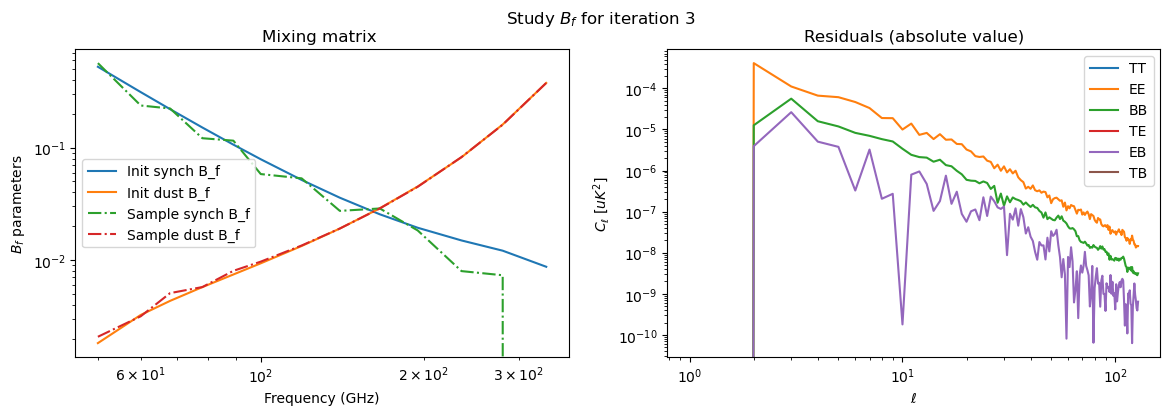

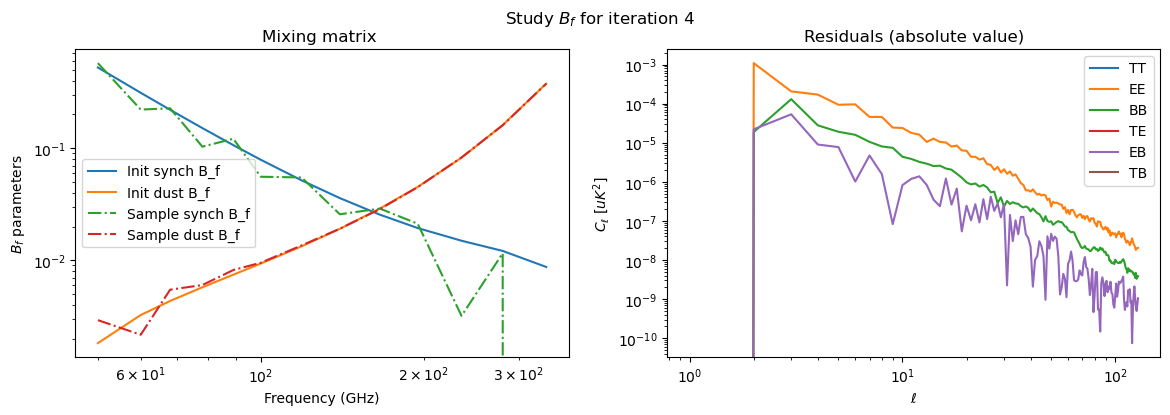

In [22]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin
min_value_mean = 3
factor_mean = (2*ell_arange[min_value_mean:] + 1)/(2*ell_arange[min_value_mean:] + 1 - 2 - 2*nstokes)

frequency_Bf = instrument['frequency'][1:-1]

for iteration in range(number_iterations_sampling):
    covariance_noise = np.zeros_like(c_ell_approx)

    mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
    mixing_matrix_sampled = mixing_matrix_obj.get_B()
    BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
    BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
    BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
    s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps, jax_use=False)[0]
    full_map_s_c = all_s_c_WF_maps[iteration] + all_s_c_fluct_maps[iteration]
    # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration,...])[lmin:]

    full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
    c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    first_residual = input_cmb_maps[0] - s_cML


    c_ell_first_residual = hp.anafast(np.vstack([np.zeros_like(first_residual[0]),first_residual]), lmax=lmax, iter=n_iter)
    ell_arange = np.arange(c_ell_first_residual.shape[1])
    
    plt.figure(figsize=(14,4))
    plt.suptitle(r"Study $B_f$ for iteration {}".format(iteration))

    plt.subplot(121)
    plt.plot(frequency_Bf, init_params[:,0], label='Init synch B_f')
    plt.plot(frequency_Bf, init_params[:,1], label='Init dust B_f')
    plt.plot(frequency_Bf, all_params_mixing_matrix_samples[iteration,:,0], '-.', label='Sample synch B_f')
    plt.plot(frequency_Bf, all_params_mixing_matrix_samples[iteration,:,1], '-.', label='Sample dust B_f')
    plt.title("Mixing matrix ")
    plt.xlabel('Frequency (GHz)')
    plt.ylabel("$B_f$ parameters")
    plt.legend()
    plt.loglog()

    plt.subplot(122)
    plt.plot(ell_arange, np.abs(c_ell_first_residual.T))
    # plt.plot(ell_arange, np.abs(c_ell_first_residual).T)
    plt.title("Residuals (absolute value)")
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel("$\ell$")
    plt.loglog()
    plt.legend(['TT', 'EE', 'BB', 'TE', 'EB', 'TB'])
    

    plt.show()